In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

from collections import Counter

In [2]:
ff_tag = ['炸鸡/鸡排/炸串', '西式快餐', '快餐简餐']

In [3]:
user_cp_df = pd.read_csv('user_cp_cleaned.csv')
user_cp_df

,user_code,food_env_bf,food_env_aft,food_env_bf_scaled,food_env_bf_category,food_env_aft_scaled,food_env_aft_category,transition_label,cp_date
0,3143106,0.192016,0.182227,19.201597,"[18.0, 20.0)",18.222721,"[18.0, 20.0)",Low to Low,63
1,6865479,0.165887,0.188367,16.588664,"[16.0, 18.0)",18.836657,"[18.0, 20.0)",Low to Low,197
2,30631766,0.191714,0.167587,19.171422,"[18.0, 20.0)",16.758721,"[16.0, 18.0)",Low to Low,106
3,58630162,0.215309,0.217823,21.530886,"[20.0, 22.0)",21.782293,"[20.0, 22.0)",High to High,62
4,65293846,0.172005,0.186580,17.200474,"[16.0, 18.0)",18.658029,"[18.0, 20.0)",Low to Low,116
...,...,...,...,...,...,...,...,...,...
1887,700110090,0.161481,0.186066,16.148069,"[16.0, 18.0)",18.606635,"[18.0, 20.0)",Low to Low,66
1888,734801344,0.183229,0.183689,18.322867,"[18.0, 20.0)",18.368866,"[18.0, 20.0)",Low to Low,131
1889,750815211,0.213089,0.207978,21.308889,"[20.0, 22.0)",20.797759,"[20.0, 22.0)",High to High,95
1890,862615939,0.176419,0.182826,17.641877,"[16.0, 18.0)",18.282607,"[18.0, 20.0)",Low to Low,314


In [4]:
user_cp_df.user_code.nunique()

1892

In [ ]:
def assign_transition_label(row, threshold=0.15):
    if row['food_env_bf'] > threshold and row['food_env_aft'] <= threshold:
        return 'High to Low'
    elif row['food_env_bf'] <= threshold and row['food_env_aft'] > threshold:
        return 'Low to High'
    elif row['food_env_bf'] > threshold and row['food_env_aft'] > threshold:
        return 'High to High'
    else:
        return 'Low to Low'

In [ ]:
def assign_transition_label1(row, threshold1=0.15, threshold2=0.15):
    if row['food_env_bf'] > threshold1 and row['food_env_aft'] <= threshold2:
        return 'High to Low'
    elif row['food_env_bf'] <= threshold2 and row['food_env_aft'] >= threshold1:
        return 'Low to High'
    elif row['food_env_bf'] >= threshold1 and row['food_env_aft'] >= threshold1:
        return 'High to High'
    elif row['food_env_bf'] <= threshold2 and row['food_env_aft'] <= threshold2:
        return 'Low to Low'
    else:
        return 'Shit'

In [ ]:
food_env_threshold = 0.20
user_cp_df['transition_label'] = user_cp_df.apply(assign_transition_label, threshold=food_env_threshold, axis=1)

In [10]:
Counter(user_cp_df.transition_label)

Counter({'Low to Low': 957,
         'High to High': 481,
         'High to Low': 246,
         'Low to High': 208})

In [ ]:
order_df = pd.read_csv('filtered_order_cp.csv')
order_df = order_df[order_df['user_code'].isin(user_cp_df['user_code'])]
order_df = pd.merge(order_df, user_cp_df[['user_code', 'transition_label', 'cp_date']], on='user_code', how='inner')
order_df['relative_day_cp'] = order_df['relative_day'] - order_df['cp_date']

In [14]:
filtered_df = order_df[(order_df['relative_day_cp'] >= -100) & (order_df['relative_day_cp'] <= 100)]
counts = filtered_df['relative_day_cp'].value_counts()

bins = list(range(0, max(counts)+101, 100))
counts_bins = pd.cut(counts, bins=bins, right=False)
range_counts = counts_bins.value_counts().sort_index()

print(range_counts)

count
[0, 100)         0
[100, 200)       0
[200, 300)       0
[300, 400)      11
[400, 500)      20
[500, 600)      26
[600, 700)      57
[700, 800)      34
[800, 900)      18
[900, 1000)     22
[1000, 1100)    11
[1100, 1200)     1
[1200, 1300)     0
[1300, 1400)     0
[1400, 1500)     0
[1500, 1600)     0
[1600, 1700)     0
[1700, 1800)     0
[1800, 1900)     0
[1900, 2000)     0
[2000, 2100)     0
[2100, 2200)     0
[2200, 2300)     0
[2300, 2400)     1
Name: count, dtype: int64


In [ ]:
relative_day_cp_counts = order_df['relative_day_cp'].value_counts()
print(relative_day_cp_counts)

relative_day_cp
 0      2367
-6      1121
-7      1092
 7      1067
-8      1064
        ... 
 484       1
 485       1
 471       1
 478       1
 479       1
Name: count, Length: 823, dtype: int64


In [ ]:
def calculate_ffo_ratio(group, ff_tag):
    ff_orders = group[group['third_tag_name'].isin(ff_tag)].shape[0]
    total_orders = group.shape[0]
    return ff_orders / total_orders if total_orders > 0 else 0

def calculate_ffo_cnt(group, ff_tag):
    ff_orders = group[group['third_tag_name'].isin(ff_tag)].shape[0]

    return ff_orders / group.user_code.nunique() if group.user_code.nunique() > 0 else 0

In [ ]:
def get_time_series(group_label, order_df, ff_tag):

    time_series = {}
    for group in group_label:
        group_data = order_df[order_df['transition_label'] == group]
        group_time_series = group_data.groupby('relative_day_cp').apply(calculate_ffo_ratio, ff_tag=ff_tag)
        time_series[group] = group_time_series
    return time_series

In [18]:
group_label = ['Low to Low', 'High to High', 'Low to High', 'High to Low']
time_series = get_time_series(group_label, order_df, ff_tag)

In [ ]:
def get_time_series_number(group_label, order_df, ff_tag):
    time_series = {}
    for group in group_label:
        group_data = order_df[order_df['transition_label'] == group]
        group_time_series = group_data.groupby('relative_day_cp').apply(calculate_ffo_cnt, ff_tag=ff_tag)
        time_series[group] = group_time_series
    return time_series

In [20]:
group_label = ['Low to Low', 'High to High', 'Low to High', 'High to Low']
time_series_tot = get_time_series_number(group_label, order_df, ff_tag)

In [ ]:
def truncate_time_series(time_series, truncate_day=100):
    truncated_series = {}
    for label, series in time_series.items():
        truncated_series[label] = series[(series.index >= -truncate_day) & (series.index <= truncate_day)]

    return truncated_series

truncate_day = 100
truncated_time_series = truncate_time_series(time_series, truncate_day=truncate_day)


truncated_time_series_cnt = truncate_time_series(time_series_tot, truncate_day=truncate_day)


In [ ]:
def plot_smoothed_time_series(truncated_series, truncate_day, window_size=0):
    for label, series in truncated_series.items():
        if window_size:
            series = series.rolling(window=window_size, center=True).mean()

        plt.figure(figsize=(6, 4))
        plt.plot(series.index, series.values, label=label)
        
        plt.title(f'FFO Orders Proportion by Relative Day CP - {label}')
        plt.xlabel('Relative Day CP')
        plt.ylabel('FFO Orders Proportion')
        plt.xlim([-truncate_day, truncate_day])
        plt.ylim([0.15, 0.45]) 
        plt.show()

In [ ]:
data_high = pd.DataFrame({
    'y': truncated_time_series['High to Low'],
    'X': truncated_time_series['High to High']
})
data_low = pd.DataFrame({
    'y': truncated_time_series['Low to High'],
    'X': truncated_time_series['Low to Low']
})

pre_period = [-100, -1]
post_period = [0, 100]


alp = 0.5

ci_high = CausalImpact(data_high, pre_period, post_period, alpha = alp)
ci_low = CausalImpact(data_low, pre_period, post_period, alpha = alp)
ci_high.run()
ci_low.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45296D+00    |proj g|=  1.89659D-01

At iterate    5    f=  1.42088D+00    |proj g|=  1.68670D-02

At iterate   10    f=  1.42078D+00    |proj g|=  3.38511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   1.372D-06   1.421D+00
  F =   1.4207777323174455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
/usr/local/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.
/usr/local/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [26]:
print(ci_high.summary())
print(ci_low.summary())

                               Average      Cumulative
Actual                               0              28
Predicted                            0              30
95% CI                          [0, 0]        [26, 34]
                                                      
Absolute Effect                      0              -2
95% CI                          [0, 0]         [1, -6]
                                                      
Relative Effect                  -7.6%           -7.6%
95% CI                  [5.3%, -20.5%]  [5.3%, -20.5%]
                                                      
P-value                           0.0%                
Prob. of Causal Effect          100.0%                
None
                                Average       Cumulative
Actual                                0               29
Predicted                             0               29
95% CI                           [0, 0]         [24, 33]
                                                    

In [ ]:

def plot_observer_predicted(data, ci, window_size=10, ymin=0.0, ymax=0.5,
                            file_name= None, file_path = None, legend = False):
    
    observed = data['y'].rolling(window=window_size, center=True).mean()
    predicted = ci.inferences['point_pred'].rolling(window=window_size, center=True).mean()
    
    lower = ci.inferences['point_pred_lower'].rolling(window=window_size, center=True).mean()
    upper = ci.inferences['point_pred_upper'].rolling(window=window_size, center=True).mean()
    
    fig, ax = plt.subplots(figsize=(5, 4))
    
    plt.plot(data.index, observed, label='Original data', color='black')
    plt.plot(data.index, predicted, label='Predicted\ncounterfactual', color='steelblue', linestyle='--')

    temp_data = data[data.index > -95]
    lower = lower[lower.index > -95]
    upper = upper[upper.index > -95]
    plt.fill_between(temp_data.index, lower, upper, color='slateblue', alpha=0.2)
    plt.axvline(x=0, color='black', linestyle='--')
    if legend:
        plt.legend(frameon = False, loc = 'center left', bbox_to_anchor = (0.5, 0.87), fontsize = 14, handletextpad = 0.1)

    plt.ylim([ymin, ymax]) 

    plt.yticks([0.2, 0.25, 0.3, 0.35, 0.4], size = 12.5)
    plt.xticks([-100, -75, -50, -25, 0, 25, 50, 75, 100], size = 12.5)

    plt.grid(lw = 0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if file_name:
        plt.savefig(file_name, transparent = True, dpi = 300)
    
    plt.show()

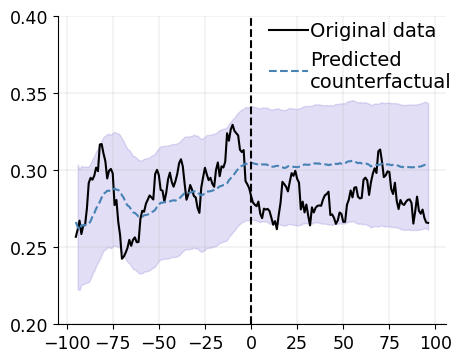

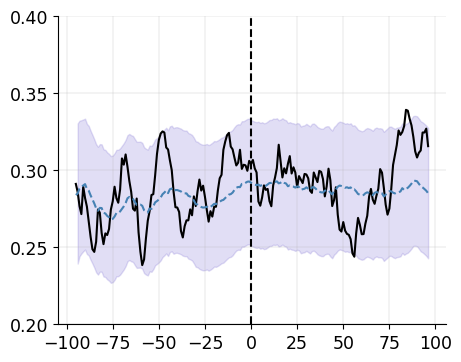

In [80]:
plot_observer_predicted(data_high, ci_high, legend = True, file_name = 'fig_BSTS/H2L_1.pdf', ymin = 0.2, ymax = 0.4)
plot_observer_predicted(data_low, ci_low, file_name = 'fig_BSTS/L2H_1.pdf', ymin = 0.2, ymax = 0.4)

In [32]:
def plot_cum_effects(data, ci, window_size=7, ymin=-5, ymax=0.5, 
                     file_name= None, file_path= None):
    index = pd.Index(range(-100, 101), name='relative_day_cp')
    
    cum_effects = ci.inferences['cum_effect'].fillna(0.0).reindex(index) \
                    .rolling(window=window_size, center=True).mean()
    cum_effects_lower = ci.inferences['cum_effect_lower'].fillna(0.0).reindex(index) \
                    .rolling(window=window_size, center=True).mean()
    cum_effects_upper = ci.inferences['cum_effect_upper'].fillna(0.0).reindex(index) \
                    .rolling(window=window_size, center=True).mean()

    fig, ax = plt.subplots(figsize=(5, 4))
    plt.plot(index, cum_effects, label='Cumulative Effect', color='black')
    # plt.plot(index, cum_effects, color='black')
    plt.fill_between(index, cum_effects_lower, cum_effects_upper, color='slateblue', alpha=0.2)
    plt.axvline(x=0, color='black', linestyle='--')
    
    # plt.legend()
    # plt.ylabel('Difference in\nShare of Fastfood Order (%)')
    # plt.xlabel('Days after changing context', size = 13)
    plt.ylim([ymin, ymax])
    # plt.tight_layout()
    plt.yticks(size = 12.5)
    plt.xticks([-100, -75, -50, -25, 0, 25, 50, 75, 100], size = 12.5)
    plt.grid(lw = 0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if file_name:
        plt.savefig(file_name, transparent = True, dpi = 300)
        
    plt.show() 

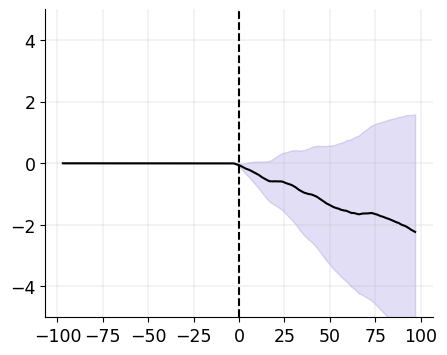

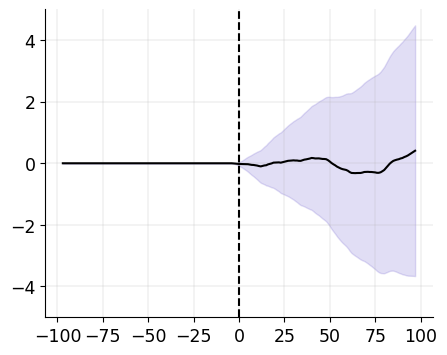

In [33]:
plot_cum_effects(data_high, ci_high, ymin = -5, ymax = 5, file_name = 'fig_BSTS/H2L_2.pdf')
plot_cum_effects(data_low, ci_low, ymin = -5, ymax = 5, file_name = 'fig_BSTS/L2H_2.pdf')